In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

In [3]:
__curdir__ = os.getcwd()

import sys
sys.path.append("../tools")

## Create tools

In [4]:
from typing import Annotated, List, Optional, Literal, Dict
from langchain_core.tools import tool
import pandas as pd

### Fundamental analysis

In [5]:
from fundamental_analysis_tools import FundamentalAnalyst

@tool
def evaluate_fundamentals(ticker: Annotated[str, "Stock ticker of interest"]) -> pd.DataFrame:
    """
    This tool is used for fundamental analysis of stock prices.
    
    The aim of fundamental analysis is to identify potentially undervalued stocks. We
    do this by ascertaining the company fundamentals and market signals:
    
    1. Gross margin (%): The ratio of the Gross profit / Total income. This informs about whether
    the company is making a profit from its sales in the market.
    2. Net Margin (%): The ratio of net proft / total income. This informs on whether the company
    makes a profit after including operating costs. 
    3. Current Ratio: The ratio of current assets/current liabilities. This informs on whether
    the company has more assets on hand than liabilities on hand.
    4. Quick Ratio: The ratio of current assets less inventory / current liabilities. This gives a
    more in-depth picture on whether the company has more assets than liabilities on hand.
    5. Return on Assets (%): Ratio of net income /total assets. Shows how much profit a company is
    able to generate from its assets.
    6. Return on Equity (%): Ratio of net income against shareholder equity. Shows how efficiently
    a company is generating income from the equity investments of shareholders.
    7. Debt to assets (%): Ratio of a company's total liabilities against total assets. Shows the
    degree to which a company has used debt to finance its assets
    8. Debt to equity (%): Ratio of a company's total liabilities to its shareholder equity. If the
    ratio is 1.5, it means the company is $1.50 in debt for every $1 of equity.
    9. P/E ratio: Ratio of share price to earnings per share. Provides an indication to whether a
    stock at its current market price is expensive (high P/E ratio) or cheap (low P/E ratio). 
    10. P/B ratio: Ratio of share price to book value (calculated as total assets - total liabilities/volume).
    A P/B ratio of less than 1 suggests a stock is undervalued.
    11. P/S ratio: Ratio of share price to (stockholders equity/volume). Indicates how much 
    investors are willing to pay. If P/S ratio is low, the stock is likely overvalued and investors
    prefer paying less.
    """
    fa = FundamentalAnalyst(ticker=ticker)
    df = fa.analyse()
    df = df.fillna(0) 
    return df

### Technical Analysis

In [6]:
from technical_analysis_tools import TechnicalAnalyst

@tool
def evaluate_technicals(
    ticker: Annotated[str, "The stock ticker of interest"],
    period: Annotated[
        Optional[
            Literal[
                "1d",
                "5d",
                "1mo",
                "3mo",
                "6mo",
                "1y",
                "2y",
                "5y",
                "10y",
                "ytd",
                "max"
            ]
        ],
        "The lookback period of interest"
    ] = "10y"
) -> pd.DataFrame:
    """
    This tool is used for technical analysis of stock prices.
    
    The technical metrics analysed are:
    1. Bollinger bands (a volatility indicator)
    2. MACD or Moving Average Convergence Divergence (a trend-following momentum indicator)
    3. Stochastic Relative Strength Index or Stoch RSI (a momentum and trend strength indicator)
    4. Stochastic Oscillator
    5. Aroon indicator (trend indicator)
    6. Accumulation/Distribution index (trend indicator), and
    7. Ichimoku indicator
    """
    analyst = TechnicalAnalyst(ticker=ticker, period=period)
    return analyst.analyse(ticker=ticker, period=period)

### Research

In [7]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders import WebBaseLoader

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [8]:
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY")
tavily_tool = TavilySearchResults(max_results=5)

In [9]:
@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

### Writing

In [10]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing_extensions import TypedDict
from langchain_experimental.utilities import PythonREPL

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)

@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file"]:
    """Create and save an outline"""
    with (WORKING_DIRECTORY/file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i+1}. {point}\n")
    return f"Outline saved to {file_name}"

@tool
def read_document(
    file_name: Annotated[str, "File path to save the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])

@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"

@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"

repl = PythonREPL()

@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"

## Utilities

In [11]:
from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph, START

In [12]:
def create_agent(
    llm: ChatOpenAI,
    tools: list,
    system_prompt: str,
) -> str:
    """Create a function-calling agent and add it to the graph."""
    system_prompt += "\nWork autonomously according to your specialty, using the tools available to you."
    " Do not ask for clarification."
    " Your other team members (and other teams) will collaborate with you with their own specialties."
    " You are chosen for a reason! You are one of the following team members: {team_members}."
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_functions_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor


def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}


def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

## Analysis Team

In [13]:
import functools
import operator
from langchain_core.messages import BaseMessage

class AnalysisTeamState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: List[str]
    next: str

llm = ChatOpenAI(model="gpt-4o-mini")

fundamentals_agent = create_agent(
    llm,
    [evaluate_fundamentals],
    "You are a fundamental analyst that helps users make investment decisions by reviewing company fundamentals."
)

fundamentals_node = functools.partial(agent_node, agent=fundamentals_agent, name="Fundamental_Analyst")

technicals_agent = create_agent(
    llm,
    [evaluate_technicals],
    "You are a technical analyst that helps users make investment decisions by undertaking technical analysis."
)

technicals_node = functools.partial(agent_node, agent=technicals_agent, name="Technical_Analyst")

supervisor_agent = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  Fundamental_Analyst, Technical_Analyst. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["Fundamental_Analyst", "Technical_Analyst"],
)

In [14]:
analysis_graph = StateGraph(AnalysisTeamState)

analysis_graph.add_node("Fundamental_Analyst", fundamentals_node)
analysis_graph.add_node("Technical_Analyst", technicals_node)
analysis_graph.add_node("supervisor", supervisor_agent)

analysis_graph.add_edge("Fundamental_Analyst", "supervisor")
analysis_graph.add_edge("Technical_Analyst", "supervisor")
analysis_graph.add_conditional_edges(
    "supervisor",
    lambda x: x['next'],
    {
        "Fundamental_Analyst": "Fundamental_Analyst", 
        "Technical_Analyst": "Technical_Analyst",
        "FINISH": END}
)

analysis_graph.add_edge(START, "supervisor")
chain = analysis_graph.compile()

In [15]:
# The following function interoperates between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results

analysis_chain = enter_chain | chain

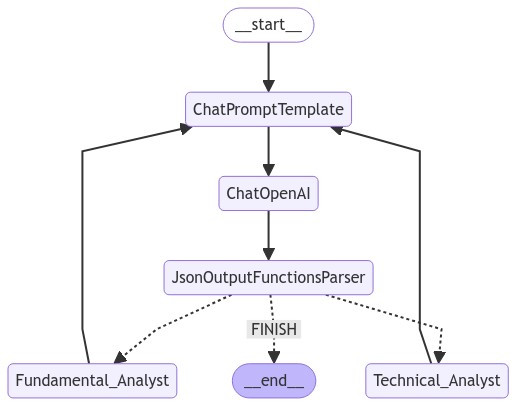

In [16]:
from IPython.display import Image, display

display(Image(chain.get_graph(xray=True).draw_mermaid_png()))

## Research Team

In [17]:
class ResearchTeamState(TypedDict):
    # A message is added after each team member finishes
    messages: Annotated[List[BaseMessage], operator.add]
    # The team members are tracked so they are aware of
    # the others' skill-sets
    team_members: List[str]
    # Used to route work. The supervisor calls a function
    # that will update this every time it makes a decision
    next: str

search_agent = create_agent(
    llm,
    [tavily_tool],
    "You are a research assistant who can search for up-to-date info using the tavily search engine.",
)
search_node = functools.partial(agent_node, agent=search_agent, name="Search")

research_agent = create_agent(
    llm,
    [scrape_webpages],
    "You are a research assistant who can scrape specified urls for more detailed information using the scrape_webpages function.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="WebScraper")

research_supervisor = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  Search, WebScraper. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["Search", "WebScraper"],
)

In [19]:
research_graph = StateGraph(ResearchTeamState)
research_graph.add_node("Search", search_node)
research_graph.add_node("WebScraper", research_node)
research_graph.add_node("supervisor", supervisor_agent)

# Define the control flow
research_graph.add_edge("Search", "supervisor")
research_graph.add_edge("WebScraper", "supervisor")
research_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"Search": "Search", "WebScraper": "WebScraper", "FINISH": END},
)


research_graph.add_edge(START, "supervisor")
research_graph_chain = research_graph.compile()

research_chain = enter_chain | research_graph_chain

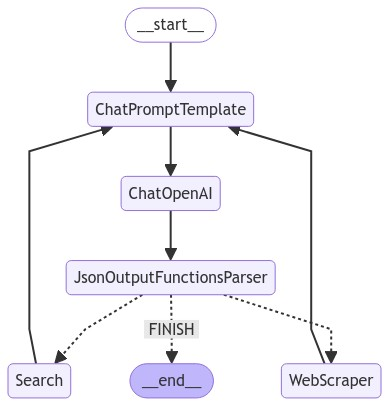

In [20]:
from IPython.display import Image, display

display(Image(research_graph_chain.get_graph(xray=True).draw_mermaid_png()))

## Document Writing Team

In [18]:
# Document writing team graph state
class DocWritingState(TypedDict):
    # This tracks the team's conversation internally
    messages: Annotated[List[BaseMessage], operator.add]
    # This provides each worker with context on the others' skill sets
    team_members: str
    # This is how the supervisor tells langgraph who to work next
    next: str
    # This tracks the shared directory state
    current_files: str

# This will be run before each worker agent begins work
# It makes it so they are more aware of the current state
# of the working directory.
def prelude(state):
    written_files = []
    if not WORKING_DIRECTORY.exists():
        WORKING_DIRECTORY.mkdir()
    try:
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
        ]
    except Exception:
        pass
    if not written_files:
        return {**state, "current_files": "No files written."}
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        + "\n".join([f" - {f}" for f in written_files]),
    }

doc_writer_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    "You are an expert writing a research document.\n"
    # The {current_files} value is populated automatically by the graph state
    "Below are files currently in your directory:\n{current_files}",
)
# Injects current directory working state before each call
context_aware_doc_writer_agent = prelude | doc_writer_agent
doc_writing_node = functools.partial(
    agent_node, agent=context_aware_doc_writer_agent, name="DocWriter"
)

note_taking_agent = create_agent(
    llm,
    [create_outline, read_document],
    "You are an expert senior researcher tasked with writing a paper outline and"
    " taking notes to craft a perfect paper.{current_files}",
)
context_aware_note_taking_agent = prelude | note_taking_agent
note_taking_node = functools.partial(
    agent_node, agent=context_aware_note_taking_agent, name="NoteTaker"
)

chart_generating_agent = create_agent(
    llm,
    [read_document, python_repl],
    "You are a data viz expert tasked with generating charts for a research project."
    "{current_files}",
)
context_aware_chart_generating_agent = prelude | chart_generating_agent
chart_generating_node = functools.partial(
    agent_node, agent=context_aware_note_taking_agent, name="ChartGenerator"
)

doc_writing_supervisor = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["DocWriter", "NoteTaker", "ChartGenerator"],
)

In [21]:
# Create the graph here:
# Note that we have unrolled the loop for the sake of this doc
authoring_graph = StateGraph(DocWritingState)
authoring_graph.add_node("DocWriter", doc_writing_node)
authoring_graph.add_node("NoteTaker", note_taking_node)
authoring_graph.add_node("ChartGenerator", chart_generating_node)
authoring_graph.add_node("supervisor", doc_writing_supervisor)

# Add the edges that always occur
authoring_graph.add_edge("DocWriter", "supervisor")
authoring_graph.add_edge("NoteTaker", "supervisor")
authoring_graph.add_edge("ChartGenerator", "supervisor")

# Add the edges where routing applies
authoring_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "DocWriter": "DocWriter",
        "NoteTaker": "NoteTaker",
        "ChartGenerator": "ChartGenerator",
        "FINISH": END,
    },
)

authoring_graph.add_edge(START, "supervisor")
chain = authoring_graph.compile()


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str, members: List[str]):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ", ".join(members),
    }
    return results


# We reuse the enter/exit functions to wrap the graph
authoring_chain = (
    functools.partial(enter_chain, members=authoring_graph.nodes)
    | authoring_graph.compile()
)

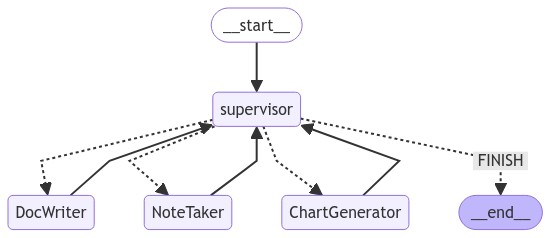

In [22]:
from IPython.display import Image, display

display(Image(chain.get_graph().draw_mermaid_png()))

## Create top level graph

In [23]:
supervisor_node = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following teams: {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["ResearchTeam", "PaperWritingTeam", "AnalysisTeam"],
)

In [24]:
# Top-level graph state
class State(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    next: str


def get_last_message(state: State) -> str:
    return state["messages"][-1].content


def join_graph(response: dict):
    return {"messages": [response["messages"][-1]]}


# Define the graph.
super_graph = StateGraph(State)
# First add the nodes, which will do the work
super_graph.add_node("AnalysisTeam", get_last_message | analysis_chain | join_graph)
super_graph.add_node("ResearchTeam", get_last_message | research_chain | join_graph)
super_graph.add_node(
    "PaperWritingTeam", get_last_message | authoring_chain | join_graph
)
super_graph.add_node("supervisor", supervisor_node)

# Define the graph connections, which controls how the logic
# propagates through the program
super_graph.add_edge("ResearchTeam", "supervisor")
super_graph.add_edge("AnalysisTeam", "supervisor")
super_graph.add_edge("PaperWritingTeam", "supervisor")
super_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "PaperWritingTeam": "PaperWritingTeam",
        "ResearchTeam": "ResearchTeam",
        "AnalysisTeam": "AnalysisTeam",
        "FINISH": END,
    },
)
super_graph.add_edge(START, "supervisor")
super_graph = super_graph.compile()

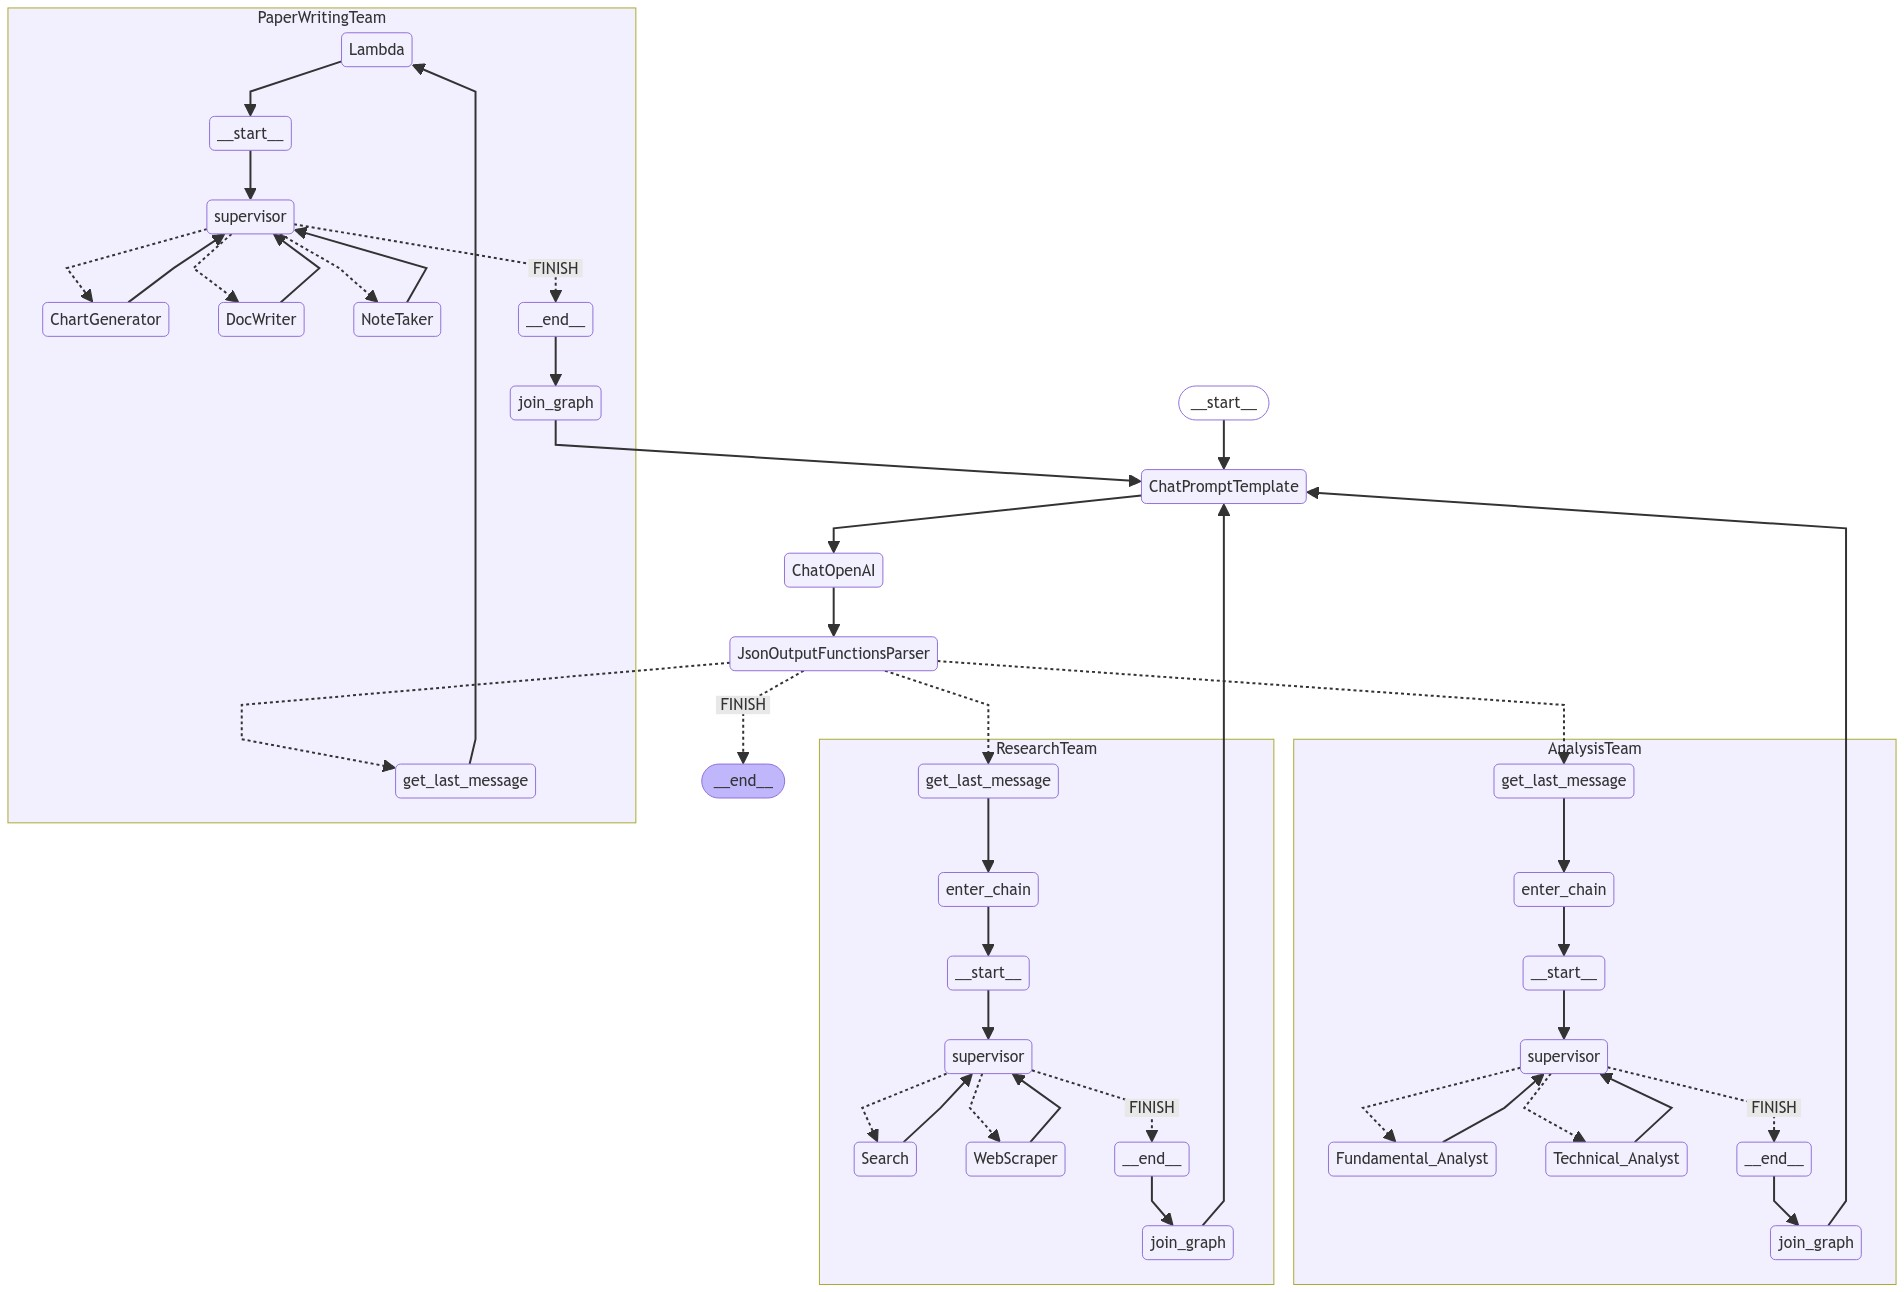

In [25]:
display(Image(super_graph.get_graph(xray=True).draw_mermaid_png()))

In [26]:
for s in super_graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Should I invest in Illuina stocks?"
            )
        ],
    },
    {"recursion_limit": 15},
):
    if "__end__" not in s:
        print(s)
        print("---")

CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.


{'supervisor': {'next': 'AnalysisTeam'}}
---


BadRequestError: Error code: 400 - {'error': {'message': "Invalid 'functions[0].description': string too long. Expected a string with maximum length 1024, but got a string with length 2030 instead.", 'type': 'invalid_request_error', 'param': 'functions[0].description', 'code': 'string_above_max_length'}}

Langgraph continues to break my heart T.T